In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

file = 'data_set_ALL_AML_train.csv'
data = pd.read_csv(file, index_col=1)
key = pd.read_csv('actual.csv', index_col=0)

sns.set()                       # sets default plot style
plt.rc('font', size=14)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=18)   # fontsize of the legend labels

drop_list = ['call'] + ['call.' + str(x) for x in range(1,38)]
data = data.drop(columns=drop_list)

#Drop the 'Gene Description' row as it is not useful here
cleaned_data = data.drop(['Gene Description'], axis=1)
cleaned_data.columns = cleaned_data.columns.map(int)
cleaned_data.sort_index(axis=1, inplace=True)

#Transpose rows and columns so that each column is a different gene
transposed_data = cleaned_data.transpose()

#Merge the key dataframe with the trimmed dataframe to assign the cancer type to each patient sample
exp_data = pd.concat([key, transposed_data], axis=1, join='inner')

#Group by cancer type to aggregate and calculate mean and std for both cancer types
df_agg_trans = exp_data.groupby('cancer').agg(['mean', 'std'])

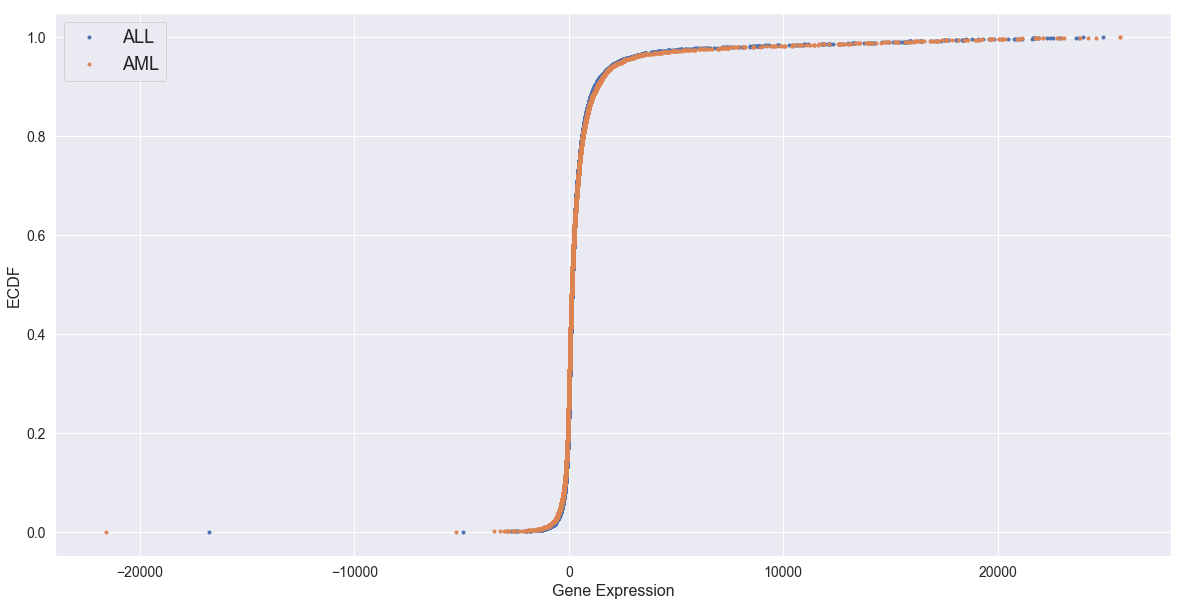

In [3]:
#Transpose dataframe so that genes form the rows
df_agg = df_agg_trans.transpose()

#Plot the empirical cumulative distribution function (ECDF) for ALL and AML mean gene expression
#First, slice out and sort ALL mean data and AML mean data to use as x-values of EDCF plots
ALL_mean = np.sort(df_agg.loc[(slice(None), 'mean'), 'ALL'])
ALL_mean = ALL_mean[ALL_mean != 0]
AML_mean = np.sort(df_agg.loc[(slice(None), 'mean'), 'AML'])
AML_mean = AML_mean[AML_mean != 0]
#Calculate y-values for ECDF plots (evenly-spaced y-values with a maximum of 1)
y = (np.arange(1, len(ALL_mean)+1)) / len(ALL_mean)

plt.figure(figsize=(20, 10))
#Generate the ALL and AML ECDF plots
plt.plot(ALL_mean, y, marker='.', linestyle='none', label='ALL')
plt.plot(AML_mean, y, marker='.', linestyle='none', label='AML')
#Adjust x-scale, label axes, add a legend, and display the plots
#plt.xscale('log')
plt.xlabel('Gene Expression')
plt.ylabel('ECDF')
plt.legend()
plt.show()

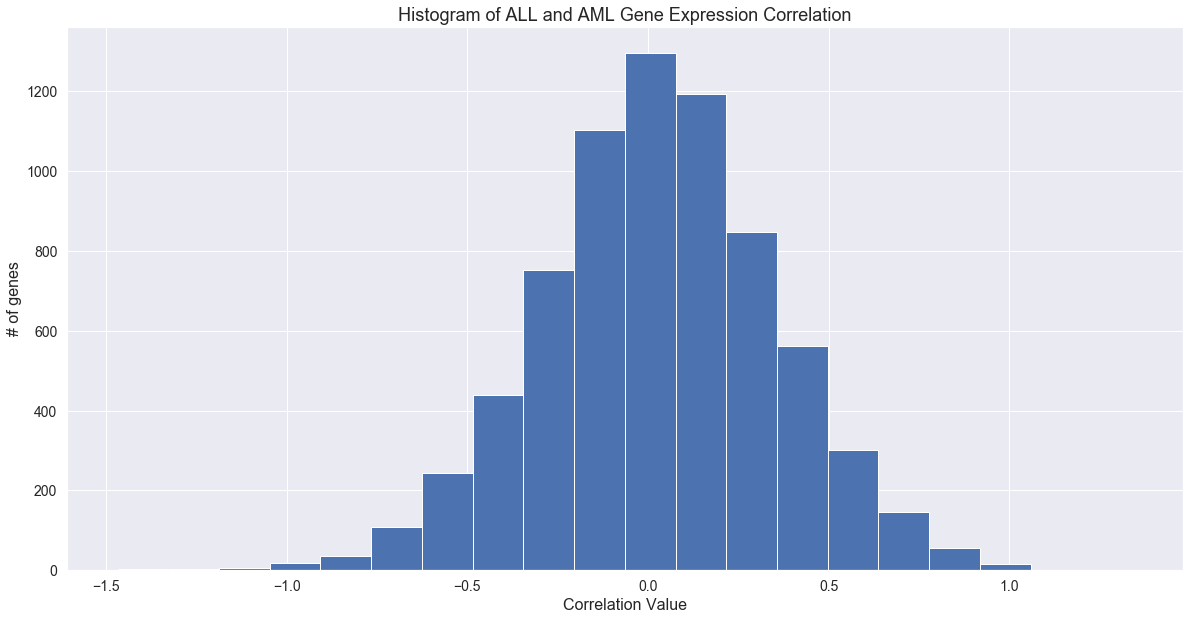

In [4]:
#Calculate the difference of ALL mean to AML mean for all genes and save in a new column, ALL:AML
df_agg.loc[(slice(None), 'mean'), 'ALL:AML'] = (df_agg['ALL'] - df_agg['AML'])
#Calculate the sum of ALL std to AML std for all genes and save column ALL:AML
df_agg.loc[(slice(None), 'std'), 'ALL:AML'] = (df_agg['ALL'] + df_agg['AML'])

mean_diff = df_agg.loc[(slice(None), 'mean'), 'ALL:AML'].copy()
mean_diff = mean_diff.reset_index(level=1)
mean_diff.drop(columns='level_1', inplace=True)
std_sum = df_agg.loc[(slice(None), 'std'), 'ALL:AML'].copy()
std_sum = std_sum.reset_index(level=1)
std_sum.drop(columns='level_1', inplace=True)

df_corr = pd.concat([mean_diff, std_sum], axis=1)
df_corr.columns = ['mean_diff', 'std_sum']

#Create a new column of the mean difference (mean_diff) over the standard deviation difference (std_diff) for each gene
df_corr.loc[:, 'correlation'] = (df_corr.mean_diff / df_corr.std_sum)

#Plot a histogram and line plot of the correlation for each gene
df_corr['correlation'].plot(kind='hist', bins=20, figsize=(20,10))
plt.title('Histogram of ALL and AML Gene Expression Correlation')
plt.xlabel('Correlation Value')
plt.ylabel('# of genes')
plt.show()

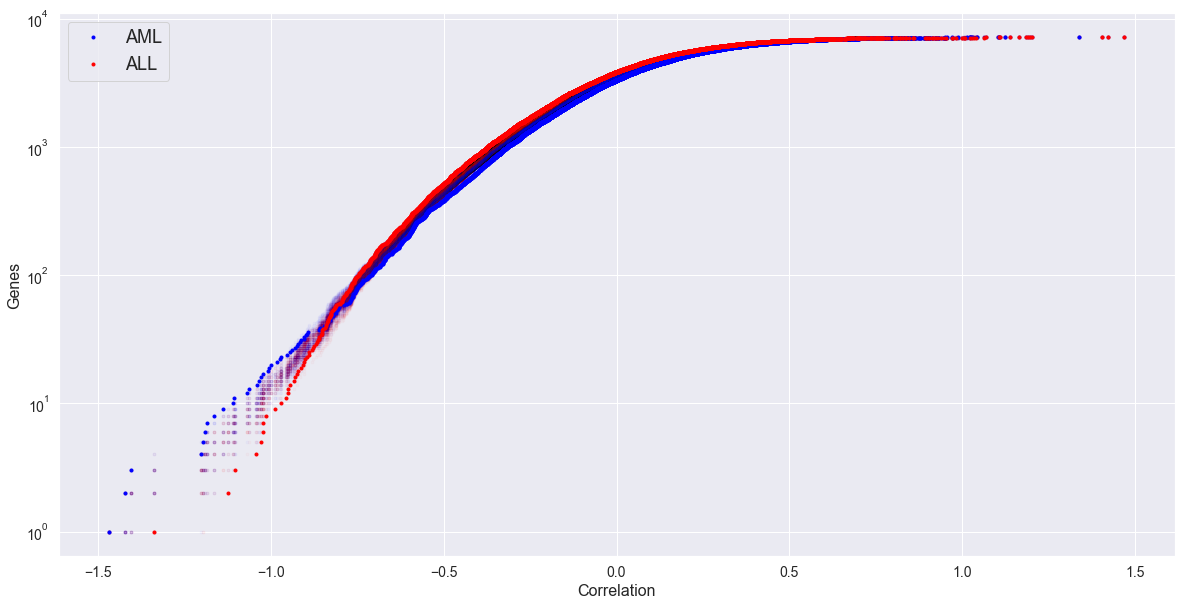

In [5]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets
    data = np.concatenate((data1, data2))

    # Permute the concatenated array
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)
    # x-data for the ECDF
    x = np.sort(data)
    # y-data for the ECDF
    y = np.arange(1, n+1)

    return x, y

AML_corr = df_corr['correlation']
ALL_corr = [-x for x in AML_corr]
plt.figure(figsize=(20, 10))

for x in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(ALL_corr, AML_corr)


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
AML_x, AML_y = ecdf(AML_corr)
ALL_x, ALL_y = ecdf(ALL_corr)

plt.plot(AML_x, AML_y, marker='.', linestyle='none', label='AML', color='blue')
plt.plot(ALL_x, ALL_y, marker='.', linestyle='none', label='ALL', color='red')
plt.yscale('log')
plt.xlabel('Correlation')
plt.ylabel('Genes')
plt.legend()
plt.show()

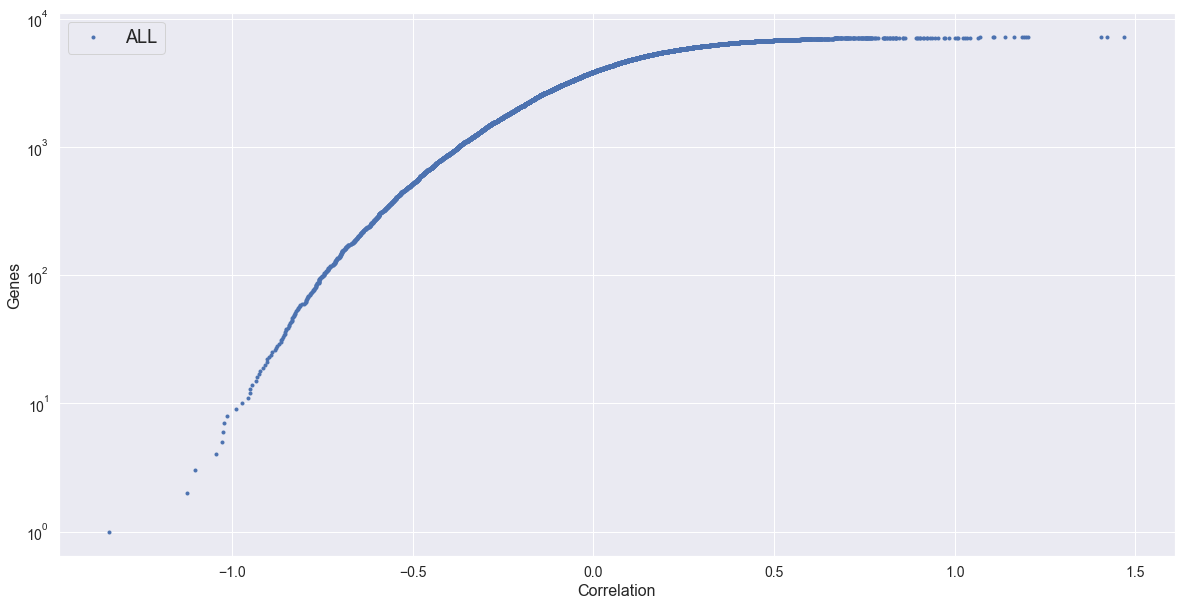

In [6]:
ALL_corr = np.sort([-x for x in AML_corr])
y = np.arange(1, len(ALL_corr)+1)

plt.figure(figsize=(20, 10))
plt.plot(ALL_corr, y, marker='.', linestyle='none', label='ALL')
plt.yscale('log')
plt.xlabel('Correlation')
plt.ylabel('Genes')
plt.legend()
plt.show()